In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy as sp
import sklearn as sk

In [3]:
df = pl.read_parquet(r'D:\20240826_week8\metashape\20241029_products_uav_data\output\extract\polygon_df\plot_1.parquet')
df =df.drop(['distance_xy','angle_rad','vaa_rad','vaa_temp'])
df

Xw,Yw,band1,band2,band3,band4,band5,elev,plot_id,delta_z,delta_x,delta_y,vza,vaa,xcam,ycam,sunelev,saa,path
f64,f64,f32,f32,f32,f32,f32,f32,str,f32,f64,f64,f64,f64,f32,f32,f32,f32,str
563623.226866,5.7130e6,0.038258,0.105588,0.04661,0.226484,0.443808,187.953659,"""plot_1""",19.592636,-13.351866,19.536939,50.38,144.380785,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif"""
563623.234118,5.7130e6,0.036556,0.10329,0.044401,0.212596,0.419656,187.951538,"""plot_1""",19.594757,-13.359118,19.536848,50.38,144.366168,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif"""
563623.241369,5.7130e6,0.035957,0.094459,0.043995,0.194316,0.399095,187.949402,"""plot_1""",19.596893,-13.366369,19.536757,50.38,144.351555,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif"""
563623.24862,5.7130e6,0.028225,0.079146,0.040325,0.170923,0.348648,187.945343,"""plot_1""",19.600952,-13.37362,19.536666,50.38,144.336948,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif"""
563623.219706,5.7130e6,0.047838,0.126558,0.054657,0.262809,0.515219,187.954254,"""plot_1""",19.592041,-13.344706,19.544281,50.38,144.405128,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
563629.951339,5.7130e6,0.007242,0.018794,0.008565,0.074818,0.21605,188.018585,"""plot_1""",19.454651,-40.326339,-1.038124,64.25,8.806903,563589.625,5.713013e6,69.225784,259.718445,"""IMG_0317_6.tif"""
563629.958591,5.7130e6,0.005833,0.018763,0.007558,0.067626,0.194563,188.023193,"""plot_1""",19.450043,-40.333591,-1.038215,64.26,8.807038,563589.625,5.713013e6,69.225784,259.718445,"""IMG_0317_6.tif"""
563629.965842,5.7130e6,0.005271,0.020969,0.008611,0.067578,0.189776,188.026062,"""plot_1""",19.447174,-40.340842,-1.038306,64.27,8.807174,563589.625,5.713013e6,69.225784,259.718445,"""IMG_0317_6.tif"""


(array([1.79000e+02, 2.04500e+03, 1.10230e+04, 2.51180e+04, 3.82410e+04,
        5.24140e+04, 6.74270e+04, 8.35600e+04, 1.02921e+05, 1.26673e+05,
        1.53636e+05, 1.81883e+05, 2.12750e+05, 2.45488e+05, 2.77302e+05,
        3.04513e+05, 3.28507e+05, 3.47763e+05, 3.61296e+05, 3.69332e+05,
        3.71414e+05, 3.71427e+05, 3.69984e+05, 3.64949e+05, 3.61181e+05,
        3.57412e+05, 3.53364e+05, 3.51071e+05, 3.45668e+05, 3.41618e+05,
        3.37508e+05, 3.33745e+05, 3.30787e+05, 3.28956e+05, 3.26168e+05,
        3.24600e+05, 3.21362e+05, 3.17820e+05, 3.13619e+05, 3.09326e+05,
        3.06465e+05, 3.02443e+05, 2.95982e+05, 2.90129e+05, 2.83816e+05,
        2.75095e+05, 2.66251e+05, 2.55739e+05, 2.43130e+05, 2.31281e+05,
        2.15841e+05, 2.02078e+05, 1.88904e+05, 1.74493e+05, 1.59186e+05,
        1.45039e+05, 1.30001e+05, 1.15662e+05, 1.01070e+05, 8.74400e+04,
        7.41650e+04, 6.40100e+04, 5.30750e+04, 4.34330e+04, 3.51450e+04,
        2.81590e+04, 2.18820e+04, 1.72860e+04, 1.33

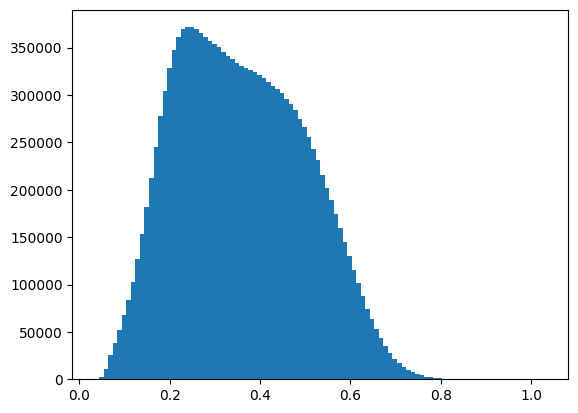

In [4]:
import random
np.random.seed(42)
subset = df.sample(n=100000, with_replacement=True, shuffle=True, seed=42)
plt.hist(df['band5'],bins=100)

In [5]:
df = df.with_columns([
    (pl.col("xcam") - pl.col("Xw")).alias("vx"),
    (pl.col("ycam") - pl.col("Yw")).alias("vy"),
    pl.col("delta_z").alias("vz"),            # already positive
])

df = df.with_columns(
    ((pl.col("vx")**2 + pl.col("vy")**2 + pl.col("vz")**2).sqrt()).alias("v_norm")
)

df = df.with_columns([
    pl.map_batches(["vz", "v_norm"], lambda zs:
           np.degrees(np.arccos(zs[0] / zs[1]))).alias("vza_deg_new"),

    pl.map_batches(["vx", "vy"], lambda xy:
           (np.degrees(np.arctan2(xy[0], xy[1])) % 360)
    ).alias("vaa_deg_new"),
])

df = df.with_columns([
    # Solar Zenith Angle (degrees)
    (90 - pl.col("sunelev")).alias("sza_deg"),
    #NDVI index
    (
            (pl.col('band5')- pl.col('band3')) /(pl.col('band5')+pl.col('band3'))
    ).alias("NDVI"),

    # View Zenith Angle (degrees)
    pl.col("vza").alias("vza_deg_new"),

    # Relative Azimuth Angle (degrees), wrapped to 0–180°
    (
        ((pl.col("saa") - pl.col("vaa_deg_new")).abs() % 360)              # raw |Δazimuth| ∈ [0, 360)
        .map_elements(                                             # clamp >180° to its supplement
            lambda x: x if x <= 180 else 360 - x,
            return_dtype=pl.Float32
        )
    ).alias("raa_deg"),

])



df

Xw,Yw,band1,band2,band3,band4,band5,elev,plot_id,delta_z,delta_x,delta_y,vza,vaa,xcam,ycam,sunelev,saa,path,vx,vy,vz,v_norm,vza_deg_new,vaa_deg_new,sza_deg,NDVI,raa_deg
f64,f64,f32,f32,f32,f32,f32,f32,str,f32,f64,f64,f64,f64,f32,f32,f32,f32,str,f64,f64,f32,f64,f64,f64,f32,f32,f32
563623.226866,5.7130e6,0.038258,0.105588,0.04661,0.226484,0.443808,187.953659,"""plot_1""",19.592636,-13.351866,19.536939,50.38,144.380785,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif""",-13.351866,19.536939,19.592636,30.721909,50.38,325.650654,25.922729,0.809919,144.380783
563623.234118,5.7130e6,0.036556,0.10329,0.044401,0.212596,0.419656,187.951538,"""plot_1""",19.594757,-13.359118,19.536848,50.38,144.366168,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif""",-13.359118,19.536848,19.594757,30.726356,50.38,325.636037,25.922729,0.80864,144.366165
563623.241369,5.7130e6,0.035957,0.094459,0.043995,0.194316,0.399095,187.949402,"""plot_1""",19.596893,-13.366369,19.536757,50.38,144.351555,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif""",-13.366369,19.536757,19.596893,30.730814,50.38,325.621424,25.922729,0.801417,144.351562
563623.24862,5.7130e6,0.028225,0.079146,0.040325,0.170923,0.348648,187.945343,"""plot_1""",19.600952,-13.37362,19.536666,50.38,144.336948,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif""",-13.37362,19.536666,19.600952,30.736499,50.38,325.606817,25.922729,0.79266,144.336945
563623.219706,5.7130e6,0.047838,0.126558,0.054657,0.262809,0.515219,187.954254,"""plot_1""",19.592041,-13.344706,19.544281,50.38,144.405128,563609.875,5.713036e6,64.077271,181.269867,"""IMG_0197_6.tif""",-13.344706,19.544281,19.592041,30.723089,50.38,325.674996,25.922729,0.808179,144.405136
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
563629.951339,5.7130e6,0.007242,0.018794,0.008565,0.074818,0.21605,188.018585,"""plot_1""",19.454651,-40.326339,-1.038124,64.25,8.806903,563589.625,5.713013e6,69.225784,259.718445,"""IMG_0317_6.tif""",-40.326339,-1.038124,19.454651,44.785877,64.25,268.525356,20.774216,0.923732,8.806911
563629.958591,5.7130e6,0.005833,0.018763,0.007558,0.067626,0.194563,188.023193,"""plot_1""",19.450043,-40.333591,-1.038215,64.26,8.807038,563589.625,5.713013e6,69.225784,259.718445,"""IMG_0317_6.tif""",-40.333591,-1.038215,19.450043,44.790408,64.26,268.525492,20.774216,0.925215,8.807047
563629.965842,5.7130e6,0.005271,0.020969,0.008611,0.067578,0.189776,188.026062,"""plot_1""",19.447174,-40.340842,-1.038306,64.27,8.807174,563589.625,5.713013e6,69.225784,259.718445,"""IMG_0317_6.tif""",-40.340842,-1.038306,19.447174,44.795694,64.27,268.525628,20.774216,0.913186,8.807183


In [6]:
import numpy as np

def rpv(angle_pack, rho0, k, theta, rc=1.0):
    s, v, rphi = np.radians(angle_pack)                 # θi, θr, Δφ  (deg → rad)
    cs, cv = np.cos(s), np.cos(v); sin_s, sin_v = np.sin(s), np.sin(v)

    g  = np.arccos(cs*cv + sin_s*sin_v*np.cos(rphi))    # phase angle
    F  = (1 - theta**2) / (1 + theta**2 - 2*theta*np.cos(np.pi - g))**1.5  # phase kernel
    G  = np.sqrt(np.tan(s)**2 + np.tan(v)**2 - 2*np.tan(s)*np.tan(v)*np.cos(rphi))
    hot= 1 + (1 - rc)/(1 + G)                           # hotspot (ρc=1 ⇒ disabled)

    return rho0 * (cs**(k-1)) * (cv**(k-1)) * (cs + cv)**(-k) * F * hot


0.3465017
ρ₀=1.3379,  k=1.972,  θ=-0.034
RMSE=0.1407,  nRMSE=39.4%


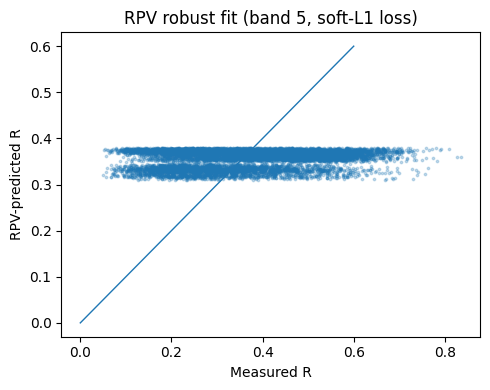

In [7]:
import numpy as np, polars as pl, matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error

band = "band5"

# ── 1. Pull filtered pixels to NumPy ───────────────────────────────
df_fit = (
    df.filter((pl.col(band).is_finite()) &
              (pl.col(band) > 0) & (pl.col(band) < 1)).sample(n=10000, with_replacement=False, shuffle=True, seed=42)
)

sza  = df_fit["sza_deg"].to_numpy()
vza  = df_fit["vza_deg_new"].to_numpy()
raa  = df_fit["raa_deg"].to_numpy()
R    = df_fit[band].to_numpy()

print(np.median(R))

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
sza, vza, raa, R = [x[mask] for x in (sza, vza, raa, R)]

# ── 2. Define residual for least_squares ───────────────────────────
def rpv_res(pars, sza, vza, raa, R):
    return rpv((sza, vza, raa), *pars) - R

# initial guess & bounds
p0      = [np.median(R), 1.2, 0.3]
bounds  = ([-1, -1, -1], [2, 5, 2])

# ── 3. Robust fit ---------------------------------------------------
res = least_squares(
        rpv_res, p0, bounds=bounds,
        args=(sza, vza, raa, R),
        loss="soft_l1",
        max_nfev=30000, verbose=0
)

rho0, k, theta = res.x
print(f"ρ₀={rho0:.4f},  k={k:.3f},  θ={theta:.3f}")

# ── 4. Evaluate metrics --------------------------------------------
R_hat = rpv((sza, vza, raa), rho0, k, theta)
rmse  = np.sqrt(mean_squared_error(R, R_hat))
nrmse = rmse / R.mean()
print(f"RMSE={rmse:.4f},  nRMSE={nrmse*100:.1f}%")

# ── 5. Scatter plot -------------------------------------------------
plt.figure(figsize=(5,4))
plt.scatter(R, R_hat, s=3, alpha=0.25)
plt.plot([0, 0.6], [0, 0.6], lw=1)
plt.xlabel("Measured R"); plt.ylabel("RPV-predicted R")
plt.title("RPV robust fit (band 5, soft-L1 loss)")
plt.tight_layout(); plt.show()


Text(0.5, 1.0, 'VZA distribution')

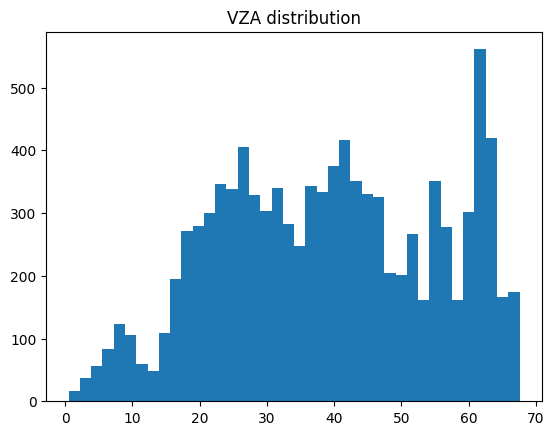

In [8]:
  plt.hist(vza, bins=40); plt.title("VZA distribution")

min / max : 0.03456559032201767 1.0321195125579834


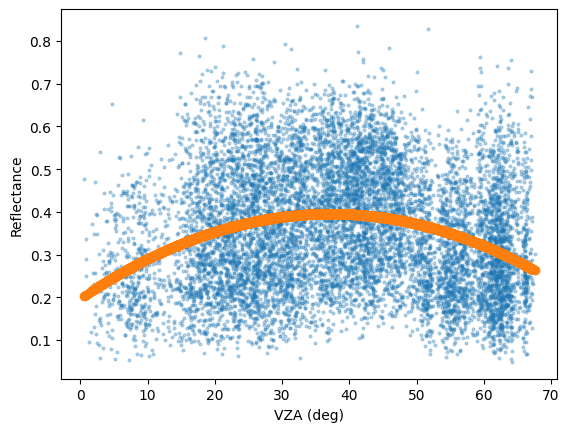

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# 1. Is reflectance well-scaled?
print("min / max :", df[band].min(), df[band].max())

# 2. Do we see any BRDF slope?
plt.scatter(df_fit["vza_deg_new"], df_fit[band], s=4, alpha=0.3)

poly = PolynomialFeatures(degree=2)
polynomial_feature = poly.fit_transform(df_fit["vza_deg_new"].to_numpy().reshape(-1, 1))

poly_reg_model = LinearRegression()
poly_reg_model.fit(polynomial_feature, df_fit[band])
y_predicted = poly_reg_model.predict(polynomial_feature)


plt.scatter(df_fit["vza_deg_new"],y_predicted, lw=1)


plt.xlabel("VZA (deg)"); plt.ylabel("Reflectance"); plt.show()



ρ₀,k,θ: [-39.36945823   1.96978833 -29.46581304]


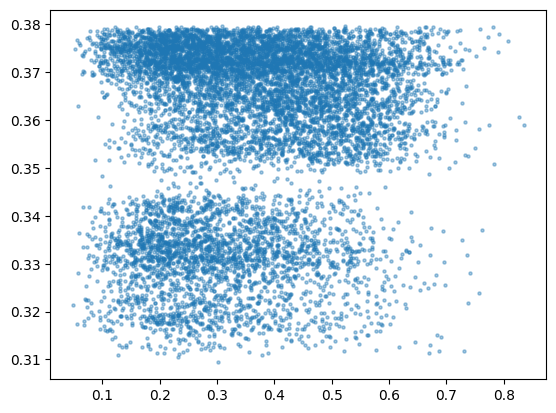

In [10]:
from scipy.optimize import curve_fit

# 3. Hard-trim obvious junk and refit
df_fit = df_fit.filter(
    (pl.col(band).is_finite()) &
    (pl.col(band) > 0.01) &          # drop ultrasmall noise
    (pl.col(band) < 0.9)            # drop clouds / glare
)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
pars, _ = curve_fit(rpv, (sza[mask], vza[mask], raa[mask]), R[mask],
                    p0=[3, -2, -2])
print("ρ₀,k,θ:", pars)
R_hat = rpv((sza, vza, raa), *pars)
plt.scatter(R, R_hat, s=5, alpha=0.4);
plt.show()


ρ₀,k,θ: [ 1.          1.7269996  -0.06474509]


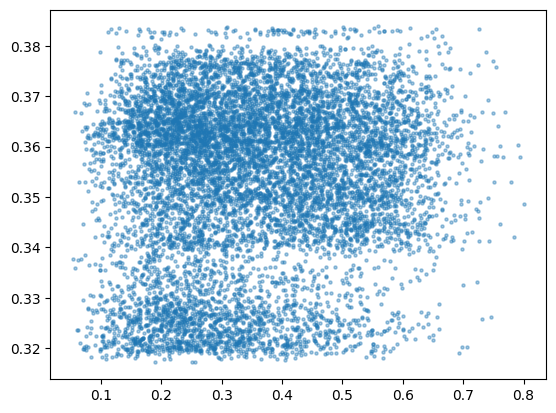

In [11]:

df_fit = df.filter((pl.col("NDVI") > 0.7) &
                   (pl.col("band5").is_finite()) &
                   (pl.col("band5") < 0.9)) .sample(n=10000, with_replacement=False)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

mask = np.isfinite(sza) & np.isfinite(vza) & np.isfinite(raa) & np.isfinite(R)
pars, _ = curve_fit(rpv, (sza[mask], vza[mask], raa[mask]), R[mask],
                    p0=[np.median(R), 1.0, 0.1], bounds=(-1, [1, 5, 1]))
print("ρ₀,k,θ:", pars)
R_hat = rpv((sza, vza, raa), *pars)
plt.scatter(R, R_hat, s=5, alpha=0.4);  plt.show()

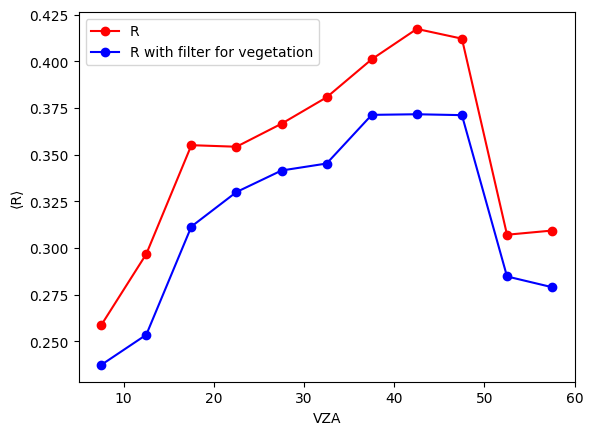

In [12]:

band = 'band5'

 #NO vegetation filter
df_fit = df.filter((pl.col("band5").is_finite()) &
                   (pl.col("band5") < 0.9)) .sample(n=10000, with_replacement=False)


sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

bins  = np.arange(5, 65, 5)
digit = np.digitize(vza, bins)
R_mean = [R[digit==i].mean() for i in range(1, len(bins))]
plt.plot(bins[:-1]+2.5, R_mean, 'o-',color='r', label='R')
plt.xlabel("VZA")
plt.ylabel("⟨R⟩")



 #With vegetation filter

df_fit = df.filter((pl.col("NDVI") > 0.8) &
                   (pl.col("band5").is_finite()) &
                   (pl.col("band5") < 0.9)) .sample(n=10000, with_replacement=False)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()

bins  = np.arange(5, 65, 5)
digit = np.digitize(vza, bins)
R_mean = [R[digit==i].mean() for i in range(1, len(bins))]
plt.plot(bins[:-1]+2.5, R_mean, 'o-',color='b', label='R with filter for vegetation')

plt.legend(loc='best')
plt.show()

C:\Users\dadoi\AppData\Local\Temp\ipykernel_8664\1588378869.py:11: RuntimeWarning: Mean of empty slice.
  mean_R  = [R[sel & ( (vza>=v) & (vza<v+4) )].mean() for v in vza_bin]
C:\Users\dadoi\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


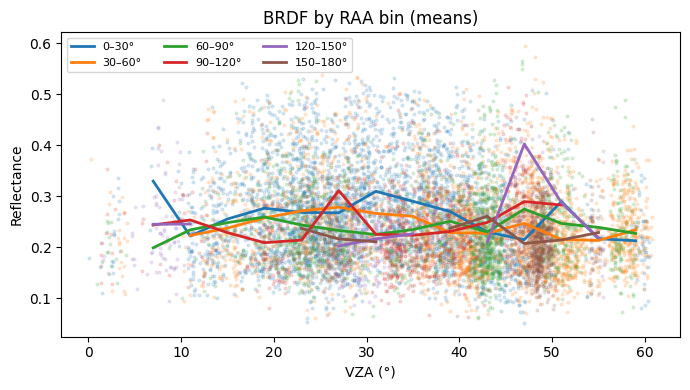

In [56]:
bins = np.arange(0, 181, 30)
col  = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"]

plt.figure(figsize=(7,4))
for i in range(len(bins)-1):
    sel = (raa>=bins[i]) & (raa<bins[i+1])
    # scatter cloud, but no label -> omitted from legend
    plt.scatter(vza[sel], R[sel], s=4, alpha=0.15, c=col[i])
    # robust central tendency per 4° VZA bin
    vza_bin = np.arange(5, 66, 4)
    mean_R  = [R[sel & ( (vza>=v) & (vza<v+4) )].mean() for v in vza_bin]
    plt.plot(vza_bin+2, mean_R, c=col[i], lw=2, label=f"{bins[i]}–{bins[i+1]}°")

plt.xlabel("VZA (°)"); plt.ylabel("Reflectance")
plt.title("BRDF by RAA bin (means)")
plt.legend(fontsize=8, ncol=3)
plt.tight_layout(); plt.show()


C:\Users\dadoi\AppData\Local\Temp\ipykernel_8664\3532487275.py:12: RuntimeWarning: Mean of empty slice.
  meanR = [R[sel & ((vza>=v)&(vza<v+4))].mean() for v in vza_bin]


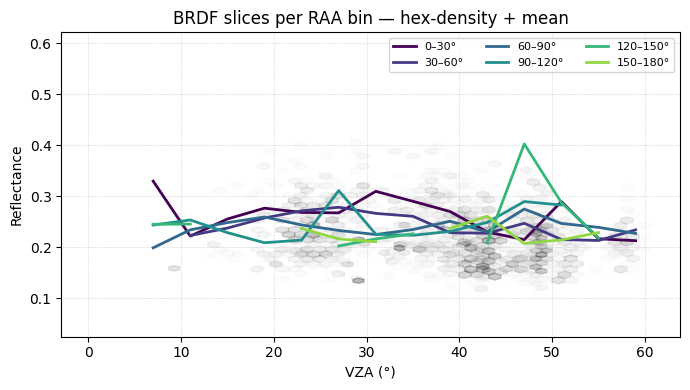

In [57]:
bins     = np.arange(0, 181, 30)
base_cmap = plt.get_cmap("viridis")
colors   = [base_cmap(i/6) for i in range(6)]
vza_bin  = np.arange(5, 66, 4)

plt.figure(figsize=(7,4))
for i,(lo,hi) in enumerate(zip(bins[:-1], bins[1:])):
    sel = (raa>=lo) & (raa<hi)
    plt.hexbin(vza[sel], R[sel], gridsize=45,
               cmap=plt.get_cmap("Greys"),
               alpha=0.25, mincnt=4)
    meanR = [R[sel & ((vza>=v)&(vza<v+4))].mean() for v in vza_bin]
    plt.plot(vza_bin+2, meanR, c=colors[i], lw=2,
             label=f"{lo}–{hi}°")

plt.xlabel("VZA (°)");  plt.ylabel("Reflectance")
plt.title("BRDF slices per RAA bin — hex-density + mean")
plt.grid(ls=":", lw=0.4);  plt.legend(ncol=3, fontsize=8)
plt.tight_layout();  plt.show()

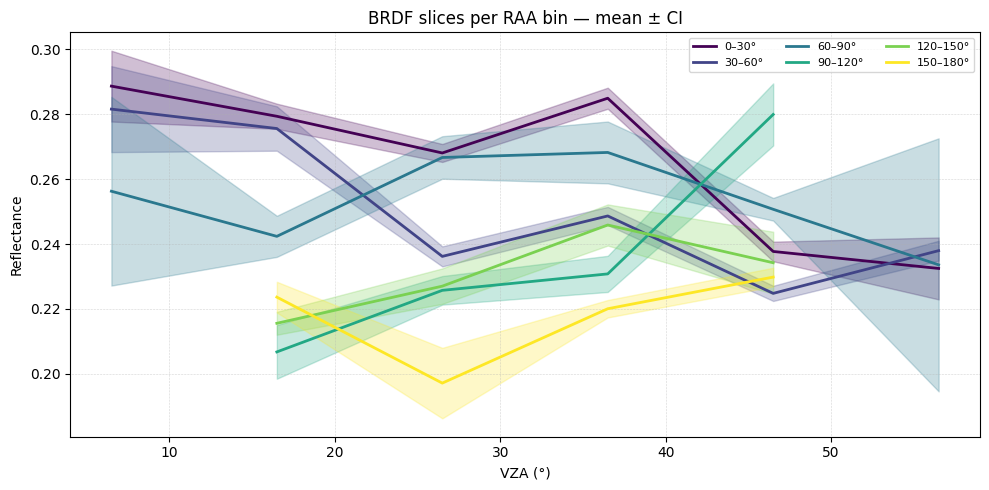

In [44]:
df_fit = df.filter((pl.col("NDVI") > 0.8) &
                   (pl.col("band5").is_finite()) &
                   (pl.col("band5") < 0.9)) .sample(n=10000, with_replacement=False)

sza = df_fit["sza_deg"].to_numpy()
vza = df_fit["vza_deg_new"].to_numpy()
raa = df_fit["raa_deg"].to_numpy()
R   = df_fit[band].to_numpy()





# parameters
bins_raa   = np.arange(0, 181, 30)
bins_vza   = np.arange(5, 66, 10)                 # 3° rolling step
colors     = plt.get_cmap("viridis")(np.linspace(0, 1, len(bins_raa)-1))

plt.figure(figsize=(10, 5))


for i, (lo, hi) in enumerate(zip(bins_raa[:-1], bins_raa[1:])):

    sel = (raa >= lo) & (raa < hi)

    idx = np.digitize(vza[sel], bins_vza) - 1     # map each VZA to a bin

    means, sigmas, counts = [], [], []

    for b in range(len(bins_vza)-1):
        r = R[sel][idx == b]
        if r.size:                                # skip empty bins
            means.append(r.mean())
            sigmas.append(r.std() / np.sqrt(r.size))
            counts.append(bins_vza[b] + 1.5)      # bin centre
    plt.plot(counts, means, c=colors[i], lw=2, label=f"{lo}–{hi}°")
    plt.fill_between(counts, np.array(means)-sigmas, np.array(means)+sigmas,
                     color=colors[i], alpha=0.25)

plt.xlabel("VZA (°)"); plt.ylabel("Reflectance")
plt.title("BRDF slices per RAA bin — mean ± CI"); plt.grid(ls=":", lw=0.4)
plt.legend(ncol=3, fontsize=8); plt.tight_layout(); plt.show()


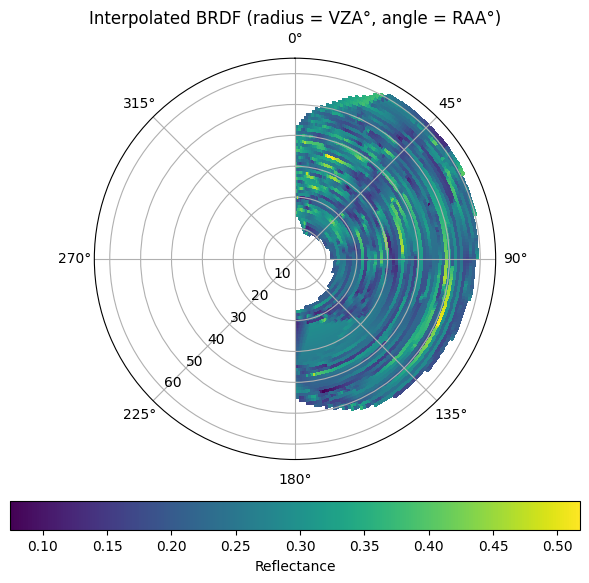

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# assume arrays raa (deg 0‑180), vza (deg 0‑65), R (reflectance) already exist
# substitute with your existing arrays when integrating

# --- 1. build regular grid ---------------------------------------------------
theta = np.linspace(0, np.pi, 181)          # 0‑180° → radians for polar
radius = np.linspace(0, 65, 66)             # VZA grid (deg)
T, R_grid = np.meshgrid(theta, radius)

# --- 2. interpolate reflectance onto grid ------------------------------------
points = np.column_stack((np.radians(raa), vza))   # original polar coords
values = R
Z = griddata(points, values, (T, R_grid), method='linear')

# mask empty cells for clarity
Z_masked = np.ma.masked_invalid(Z)

# --- 3. polar plot ------------------------------------------------------------
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='polar')
pcm = ax.pcolormesh(T, R_grid, Z_masked, shading='nearest', cmap='viridis')
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)      # 0° = north, clockwise
ax.set_rlim(0, 65); ax.set_rlabel_position(225)
ax.set_title("Interpolated BRDF (radius = VZA°, angle = RAA°)")
cbar = plt.colorbar(pcm, orientation='horizontal', pad=0.08)
cbar.set_label("Reflectance")
plt.tight_layout()
plt.show()
